In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
pvgis_file = 'pvgis.csv'

# Skip the first 8 lines (adjust if your metadata is longer/shorter)
pvgis_df = pd.read_csv(
    pvgis_file,
    skiprows=8,       # skip metadata
    sep=',',          # comma-separated
    skip_blank_lines=True,
    on_bad_lines='skip'
)

# Convert 'time' column to datetime
pvgis_df['time'] = pd.to_datetime(pvgis_df['time'], format='%Y%m%d:%H%M', errors='coerce')

# Drop rows where conversion failed
pvgis_df = pvgis_df.dropna(subset=['time'])

# Preview
pvgis_df.head()

,time,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int
0,2006-01-01 00:30:00,0.0,0.00,0.00,0.00,23.09,2.97,0.0
1,2006-01-01 01:30:00,38.42,22.30,0.14,5.54,23.10,3.03,0.0
2,2006-01-01 02:30:00,146.89,93.94,0.65,18.50,23.72,3.45,0.0
3,2006-01-01 03:30:00,183.13,175.71,1.04,30.69,24.38,3.79,0.0
4,2006-01-01 04:30:00,286.14,233.28,1.51,41.51,24.28,4.69,0.0


In [5]:
household_file = 'household_power_consumption.txt'

# Read TXT file with ; delimiter
consumption_df = pd.read_csv(household_file, sep=';', low_memory=False)

# Combine 'Date' and 'Time' into a single datetime column
consumption_df['time'] = pd.to_datetime(consumption_df['Date'] + ' ' + consumption_df['Time'], 
                                        format='%d/%m/%Y %H:%M:%S', errors='coerce')

# Drop rows where conversion failed
consumption_df = consumption_df.dropna(subset=['time'])

# Keep only relevant columns
consumption_df = consumption_df[['time', 'Global_active_power']]

# Rename for simplicity
consumption_df.rename(columns={'Global_active_power': 'consumption'}, inplace=True)

# Preview
consumption_df.head()


,time,consumption
0,2006-12-16 17:24:00,4.216
1,2006-12-16 17:25:00,5.360
2,2006-12-16 17:26:00,5.374
3,2006-12-16 17:27:00,5.388
4,2006-12-16 17:28:00,3.666


In [6]:
# Merge on 'time'
merged_df = pd.merge(consumption_df, pvgis_df, on='time', how='inner')

# Preview merged data
merged_df.head()

,time,consumption,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int
0,2006-12-16 17:30:00,3.702,0.0,0.0,0.0,0.0,25.32,4.55,0.0
1,2006-12-16 18:30:00,2.930,0.0,0.0,0.0,0.0,25.43,4.48,0.0
2,2006-12-16 19:30:00,3.408,0.0,0.0,0.0,0.0,24.96,4.48,0.0
3,2006-12-16 20:30:00,3.262,0.0,0.0,0.0,0.0,24.70,4.28,0.0
4,2006-12-16 21:30:00,3.226,0.0,0.0,0.0,0.0,24.72,4.14,0.0


In [7]:
# Replace '?' with NaN
merged_df.replace('?', np.nan, inplace=True)

# Convert all numeric columns to float
numeric_cols = ['consumption', 'Gb(i)', 'Gd(i)', 'Gr(i)', 'H_sun', 'T2m', 'WS10m', 'Int']
for col in numeric_cols:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Fill remaining NaNs with 0 (or you can use interpolate if preferred)
merged_df[numeric_cols] = merged_df[numeric_cols].fillna(0)

print("Check data after conversion:")
print(merged_df.head())

Check data after conversion:
                 time  consumption  Gb(i)  Gd(i)  Gr(i)  H_sun    T2m  WS10m  \
0 2006-12-16 17:30:00        3.702    0.0    0.0    0.0    0.0  25.32   4.55   
1 2006-12-16 18:30:00        2.930    0.0    0.0    0.0    0.0  25.43   4.48   
2 2006-12-16 19:30:00        3.408    0.0    0.0    0.0    0.0  24.96   4.48   
3 2006-12-16 20:30:00        3.262    0.0    0.0    0.0    0.0  24.70   4.28   
4 2006-12-16 21:30:00        3.226    0.0    0.0    0.0    0.0  24.72   4.14   

   Int  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  


In [8]:
df = merged_df.copy()

# Extract time-based features
df['hour'] = df['time'].dt.hour
df['dayofweek'] = df['time'].dt.dayofweek  # Monday=0, Sunday=6

# Cyclic encoding for hour (24h cycle)
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

# Cyclic encoding for day of week (7-day cycle)
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)
# More lag features (t-1 to t-6)
for lag in range(1, 7):
    df[f'consumption_lag{lag}'] = df['consumption'].shift(lag)
    df[f'Gb_lag{lag}'] = df['Gb(i)'].shift(lag)
    df[f'Gd_lag{lag}'] = df['Gd(i)'].shift(lag)
    df[f'Gr_lag{lag}'] = df['Gr(i)'].shift(lag)
    df[f'H_sun_lag{lag}'] = df['H_sun'].shift(lag)

# Rolling averages (short-term history)
df['consumption_roll3'] = df['consumption'].rolling(3).mean()
df['consumption_roll6'] = df['consumption'].rolling(6).mean()

df = df.dropna().reset_index(drop=True)
print("Data shape after lags + rolling:", df.shape)


Data shape after lags + rolling: (34582, 47)


In [9]:
drop_cols = ['time', 'consumption', 'hour', 'dayofweek']
feature_cols = [col for col in df.columns if col not in drop_cols]

X = df[feature_cols]
y = df['consumption']

print(X.shape, y.shape)


(34582, 43) (34582,)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)


(27665, 43) (6917, 43)


In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


C:\Users\manoj\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2871 - mae: 0.3465 - val_loss: 0.0245 - val_mae: 0.1249
Epoch 2/300
865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0563 - mae: 0.1667 - val_loss: 0.0144 - val_mae: 0.0912
Epoch 3/300
865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0334 - mae: 0.1278 - val_loss: 0.0199 - val_mae: 0.1012
Epoch 4/300
865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0243 - mae: 0.1085 - val_loss: 0.0285 - val_mae: 0.1081
Epoch 5/300
865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0195 - mae: 0.0976 - val_loss: 0.0200 - val_mae: 0.1016
Epoch 6/300
865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0168 - mae: 0.0902 - val_loss: 0.0306 - val_mae: 0.1119
Epoch 7/300
865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0147 - mae: 0.0851 - val_loss: 0.0291 - val_mae: 0.1115
Epoch 8/300
865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0136 - mae: 0.0809 - val_loss: 0.0263 - val_mae: 0.1129
Epoch 9/300
865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/

In [12]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.3f}, R2: {train_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}, R2: {test_r2:.3f}")


865/865 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Train RMSE: 0.122, R2: 0.988
Test RMSE: 0.120, R2: 0.981


In [13]:
# Drop unnecessary columns and define features + target
drop_cols = ['time', 'consumption', 'hour', 'dayofweek']
feature_cols = [col for col in df.columns if col not in drop_cols]

X = df[feature_cols]
y = df['consumption']

print("Features used in training:")
print(X.columns.tolist())



Features used in training:
['Gb(i)', 'Gd(i)', 'Gr(i)', 'H_sun', 'T2m', 'WS10m', 'Int', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'consumption_lag1', 'Gb_lag1', 'Gd_lag1', 'Gr_lag1', 'H_sun_lag1', 'consumption_lag2', 'Gb_lag2', 'Gd_lag2', 'Gr_lag2', 'H_sun_lag2', 'consumption_lag3', 'Gb_lag3', 'Gd_lag3', 'Gr_lag3', 'H_sun_lag3', 'consumption_lag4', 'Gb_lag4', 'Gd_lag4', 'Gr_lag4', 'H_sun_lag4', 'consumption_lag5', 'Gb_lag5', 'Gd_lag5', 'Gr_lag5', 'H_sun_lag5', 'consumption_lag6', 'Gb_lag6', 'Gd_lag6', 'Gr_lag6', 'H_sun_lag6', 'consumption_roll3', 'consumption_roll6']


865/865 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


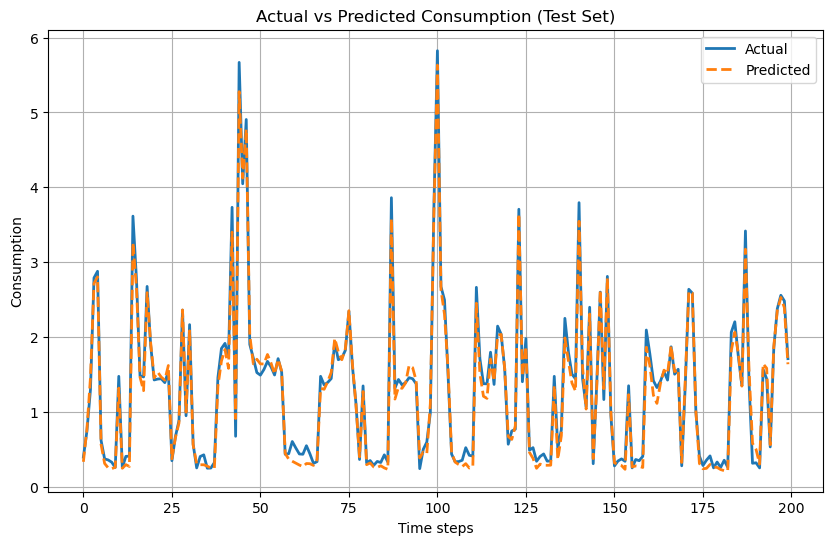

In [14]:
import matplotlib.pyplot as plt

# Predict on train and test sets
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Plot actual vs predicted for test set
plt.figure(figsize=(10,6))
plt.plot(y_test.values[:200], label="Actual", linewidth=2)   # first 200 points for clarity
plt.plot(y_test_pred[:200], label="Predicted", linewidth=2, linestyle='dashed')
plt.title("Actual vs Predicted Consumption (Test Set)")
plt.xlabel("Time steps")
plt.ylabel("Consumption")
plt.legend()
plt.grid(True)
plt.show()


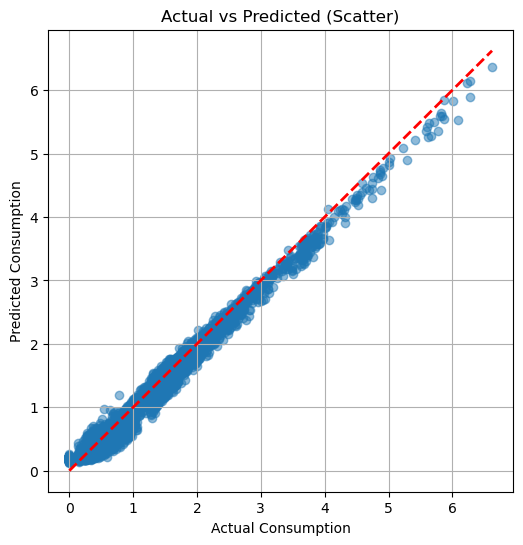

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Consumption")
plt.ylabel("Predicted Consumption")
plt.title("Actual vs Predicted (Scatter)")
plt.grid(True)
plt.show()
